/var/folders/yp/6mn1n00s6zg4_6vww8ksl5tw0000gn/T/ipykernel_38055/2093451055.py:11: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  macro['quarter'] = pd.PeriodIndex(
/Users/ashkan/Documents/projects.nosync/sandbox/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


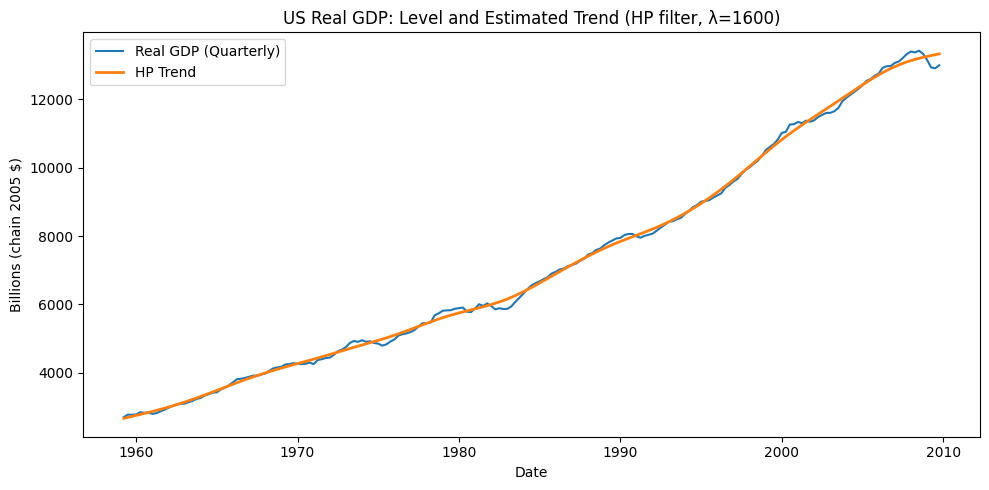

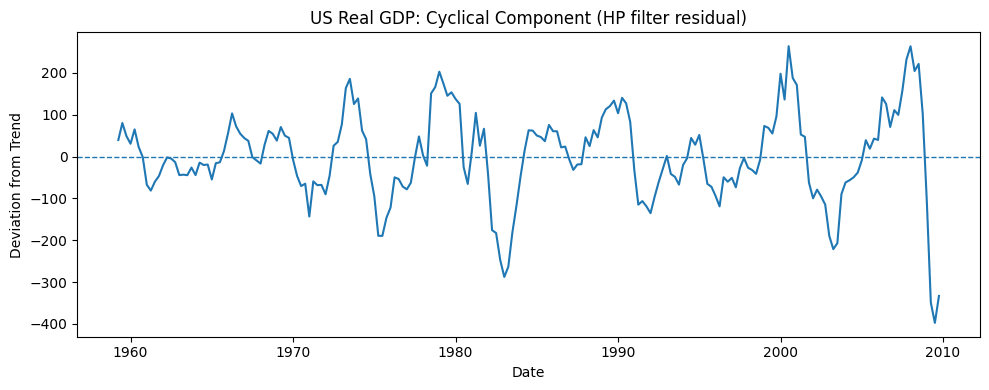

In [1]:
# Real GDP decomposition into trend and cycle using HP filter
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

# 1) Load quarterly US macro data from statsmodels (1959Q1–2009Q3)
macro = sm.datasets.macrodata.load_pandas().data.copy()

# Build a proper quarterly index and select real GDP
macro['quarter'] = pd.PeriodIndex(
    year=macro['year'].astype(int),
    quarter=macro['quarter'].astype(int),
    freq='Q'
)
gdp = macro.set_index(macro['quarter'].astype(str))['realgdp'].astype(float)
gdp.index = pd.PeriodIndex(gdp.index, freq='Q').to_timestamp(how='end')

# 2) HP filter (λ=1600 for quarterly data)
cycle, trend = hpfilter(gdp, lamb=1600)

# 3) Plot: GDP level + trend
plt.figure(figsize=(10, 5))
plt.plot(gdp.index, gdp.values, label='Real GDP (Quarterly)')
plt.plot(trend.index, trend.values, label='HP Trend', linewidth=2)
plt.title('US Real GDP: Level and Estimated Trend (HP filter, λ=1600)')
plt.xlabel('Date')
plt.ylabel('Billions (chain 2005 $)')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Plot: cyclical component (deviation from trend)
plt.figure(figsize=(10, 4))
plt.plot(cycle.index, cycle.values, label='Cyclical Component')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('US Real GDP: Cyclical Component (HP filter residual)')
plt.xlabel('Date')
plt.ylabel('Deviation from Trend')
plt.tight_layout()
plt.show()


/Users/ashkan/Documents/projects.nosync/sandbox/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/Users/ashkan/Documents/projects.nosync/sandbox/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


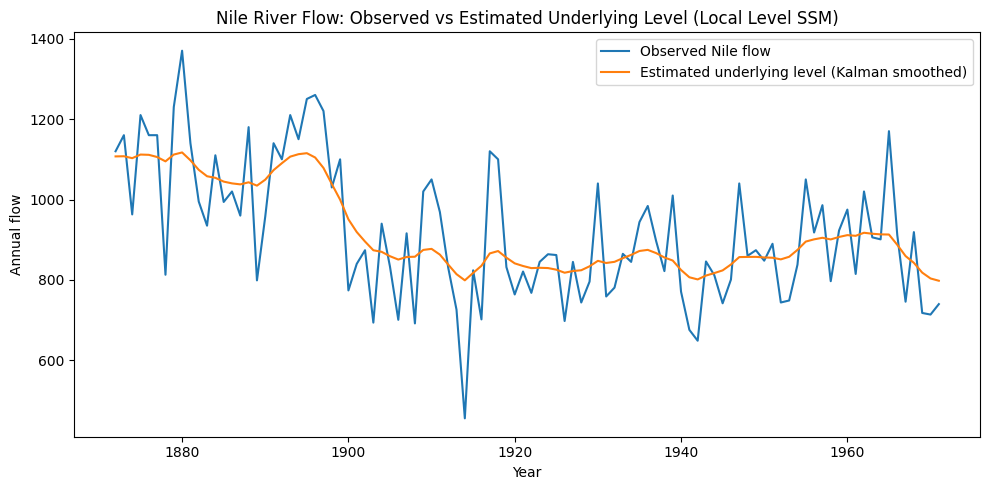

In [4]:
# State-Space Models in Practice:
# 1) Nile River (Local Level SSM)
# 2) U.S. Real GDP (Local Linear Trend + Cycle)
#
# Outputs three figures:
#   - Nile: observed vs smoothed level
#   - GDP: observed vs smoothed trend
#   - GDP: smoothed cycle
# You can optionally save them by uncommenting the plt.savefig(...) lines.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -----------------------------
# 1) Nile River: Local Level SSM
# -----------------------------
nile = sm.datasets.nile.load_pandas().data.copy()
# Build a proper annual time index
nile.index = pd.PeriodIndex(nile['year'].astype(int), freq='Y').to_timestamp(how='end')
y_nile = nile['volume'].astype(float)

# Local level model (random-walk level + observation noise)
mod_nile = sm.tsa.UnobservedComponents(y_nile, level='local level')
res_nile = mod_nile.fit(disp=False)

# Smoothed level (underlying state estimate)
try:
    level_smoothed = res_nile.level['smoothed']  # available on recent statsmodels
except Exception:
    # Fallback: take first row of smoothed_state matrix
    level_smoothed = pd.Series(
        res_nile.filter_results.smoothed_state[0],
        index=y_nile.index,
        name="level_smoothed"
    )

# Plot: Observed vs Smoothed Level
plt.figure(figsize=(10, 5))
plt.plot(y_nile.index, y_nile.values, label="Observed Nile flow")
plt.plot(y_nile.index, level_smoothed, label="Estimated underlying level (Kalman smoothed)")
plt.title("Nile River Flow: Observed vs Estimated Underlying Level (Local Level SSM)")
plt.xlabel("Year")
plt.ylabel("Annual flow")
plt.legend()
plt.tight_layout()
# plt.savefig("nile_observed_vs_level.png", dpi=160)
plt.show()

M = 6.31


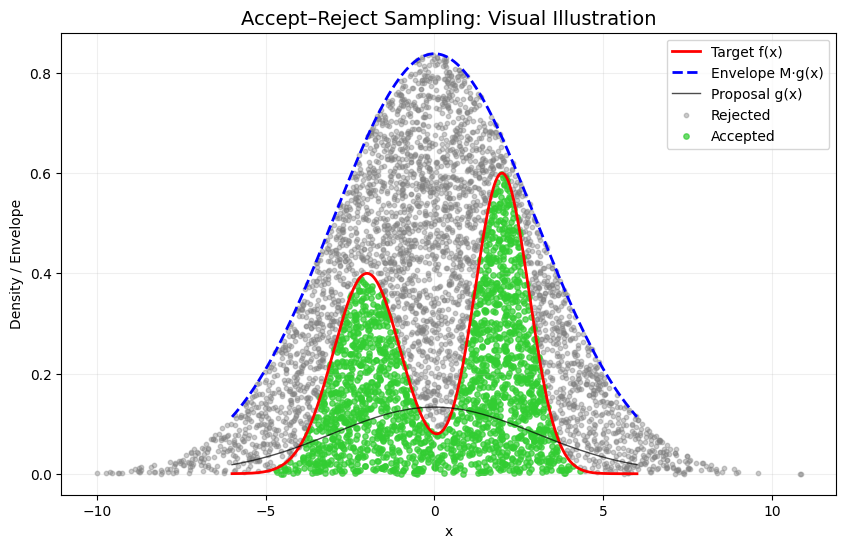

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Target: Mixture of two Gaussians (unnormalized)
def f(x):
    return 0.6*np.exp(-0.5*((x-2)/0.8)**2) + 0.4*np.exp(-0.5*((x+2)/1.0)**2)

# Proposal: Normal(0, 3)
def g(x):
    return (1/np.sqrt(2*np.pi*3**2))*np.exp(-x**2/(2*3**2))

# Sampling from proposal
def g_sample(n):
    return np.random.normal(0, 3, n)

# Find scaling constant M
x_grid = np.linspace(-6, 6, 1000)
M = np.max(f(x_grid) / g(x_grid)) * 1.1  # small buffer
print(f"M = {M:.2f}")

# Accept–Reject Sampling
N = 5000
x_samples = g_sample(N)
u = np.random.rand(N)
accepted = []
rejected = []
for i in range(N):
    if u[i] < f(x_samples[i]) / (M * g(x_samples[i])):
        accepted.append((x_samples[i], u[i]))
    else:
        rejected.append((x_samples[i], u[i]))
accepted = np.array(accepted)
rejected = np.array(rejected)

# Plot target, proposal, and points
plt.figure(figsize=(10,6))
plt.plot(x_grid, f(x_grid), 'r-', lw=2, label='Target f(x)')
plt.plot(x_grid, M*g(x_grid), 'b--', lw=2, label='Envelope M·g(x)')
plt.plot(x_grid, g(x_grid), 'k-', lw=1, alpha=0.7, label='Proposal g(x)')

# Plot accepted and rejected points
plt.scatter(rejected[:,0], rejected[:,1]*M*g(rejected[:,0]), s=10, c='grey', alpha=0.4, label='Rejected')
plt.scatter(accepted[:,0], accepted[:,1]*M*g(accepted[:,0]), s=15, c='limegreen', alpha=0.7, label='Accepted')

plt.title("Accept–Reject Sampling: Visual Illustration", fontsize=14)
plt.xlabel("x")
plt.ylabel("Density / Envelope")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


M = 8.00


/var/folders/yp/6mn1n00s6zg4_6vww8ksl5tw0000gn/T/ipykernel_75189/507829014.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x_grid, f(x_grid)/np.trapz(f(x_grid), x_grid), 'r-', lw=2, label='Target (normalized)')


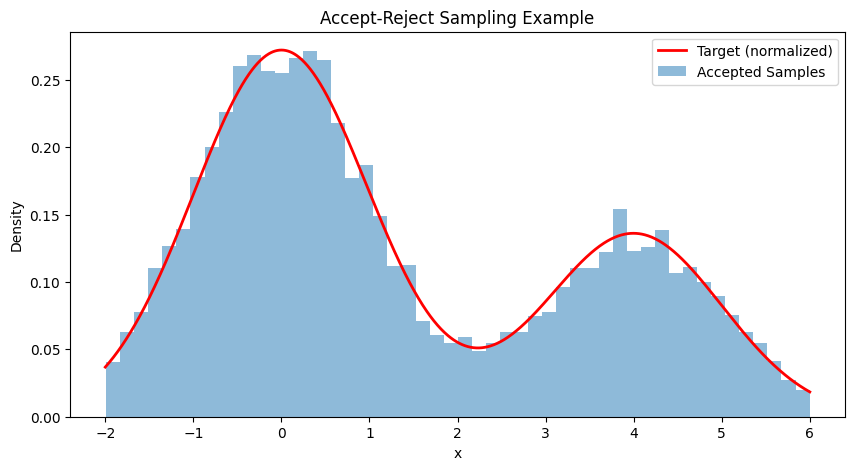

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Target density (unnormalized)
def f(x):
    return np.exp(-x**2 / 2) + 0.5 * np.exp(-(x - 4)**2 / 2)

# Proposal distribution g(x): Uniform(-2, 6)
def g_sample(n=1):
    return np.random.uniform(-2, 6, n)

def g_pdf(x):
    return np.where((x >= -2) & (x <= 6), 1/8, 0)

# Find M so that f(x) <= M * g(x)
x_grid = np.linspace(-2, 6, 1000)
M = np.max(f(x_grid) / g_pdf(x_grid))
print(f"M = {M:.2f}")

# Accept-Reject Sampling
N = 10000
samples = []
while len(samples) < N:
    x = g_sample(1)
    u = np.random.rand()
    if u < f(x) / (M * g_pdf(x)):
        samples.append(x[0])
samples = np.array(samples)

# Plot
plt.figure(figsize=(10,5))
plt.plot(x_grid, f(x_grid)/np.trapz(f(x_grid), x_grid), 'r-', lw=2, label='Target (normalized)')
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Accepted Samples')
plt.title("Accept-Reject Sampling Example")
plt.xlabel("x"); plt.ylabel("Density")
plt.legend()
plt.show()


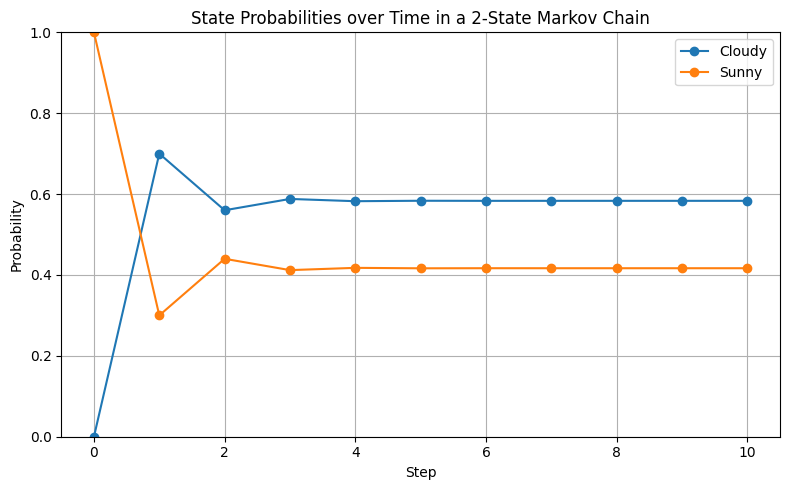

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Markov chain setup ----
# States order: [Sunny, Cloudy]
P = np.array([
    [0.3, 0.7],   # from Sunny -> [Sunny, Cloudy]
    [0.5, 0.5],   # from Cloudy -> [Sunny, Cloudy]
])

# Initial distribution (100% Sunny). Change if you want, e.g. [0.6, 0.4]
pi0 = np.array([1.0, 0.0])

# ---- Evolve probabilities ----
steps = 10  # number of transitions to show
probs = [pi0]
pi = pi0.copy()
for _ in range(steps):
    pi = pi @ P
    probs.append(pi)

probs = np.array(probs)   # shape: (steps+1, 2)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(probs[:, 1], marker='o', label='Cloudy')
plt.plot(probs[:, 0], marker='o', label='Sunny')
plt.title('State Probabilities over Time in a 2-State Markov Chain')
plt.xlabel('Step')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


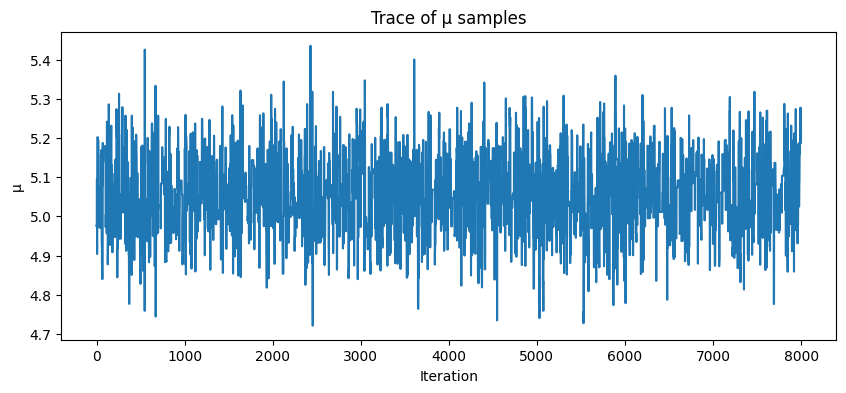

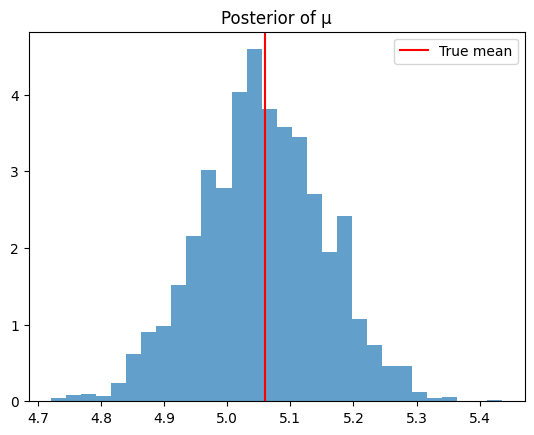

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# generate data
np.random.seed(0)
y = np.random.normal(5, 1, 100)

# log posterior (up to constant)
def log_posterior(mu):
    ll = -0.5 * np.sum((y - mu)**2)      # log-likelihood
    prior = -0.5 * (mu/10)**2            # log-prior
    return ll + prior

# MCMC sampler
N = 10000
chain = np.zeros(N)
mu_current = 0

for i in range(1, N):
    proposal = mu_current + np.random.normal(0, 0.5)
    accept_ratio = np.exp(log_posterior(proposal) - log_posterior(mu_current))
    if np.random.rand() < accept_ratio:
        mu_current = proposal
    chain[i] = mu_current

# discard burn-in
chain_burned = chain[2000:]

plt.figure(figsize=(10,4))
plt.plot(chain_burned)
plt.title("Trace of μ samples")
plt.xlabel("Iteration"); plt.ylabel("μ")
plt.show()

plt.figure()
plt.hist(chain_burned, bins=30, density=True, alpha=0.7)
plt.axvline(np.mean(y), color='r', label='True mean')
plt.legend(); plt.title("Posterior of μ")
plt.show()



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.651,0.054,0.549,0.755,0.001,0.001,6331.0,5178.0,1.0
sigma,0.932,0.047,0.845,1.023,0.001,0.001,6947.0,5616.0,1.0


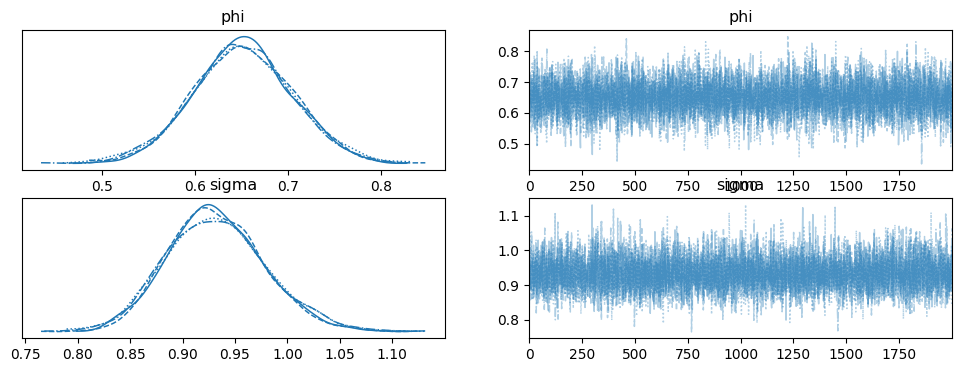

In [37]:
# pip install pymc
import pymc as pm
import arviz as az

np.random.seed(42)
phi_true, sigma_true = 0.7, 1
n = 200
y = np.zeros(n)
for t in range(1, n): y[t] = phi_true*y[t-1] + np.random.normal(0, sigma_true)

with pm.Model() as model:
    phi = pm.Normal("phi", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    yhat = pm.Normal("yhat", mu=phi*y[:-1], sigma=sigma, observed=y[1:])
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

az.plot_trace(trace)
az.summary(trace, var_names=["phi", "sigma"])
